In [88]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import seaborn as sns

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

LMS 클라우드 서버 내 나의 폴더 지정

In [90]:
PATH = "/aiffel/aiffel/aiffel/explorations/06_kaggle/data"

In [91]:
train_data_path = join(PATH, 'train.csv')
test_data_path = join(PATH, 'test.csv')

print(train_data_path, test_data_path)

/aiffel/aiffel/aiffel/explorations/06_kaggle/data/train.csv /aiffel/aiffel/aiffel/explorations/06_kaggle/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [92]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [93]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [94]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## corrwith 함수로 상관계수 구하기
pearson

In [99]:
train.corrwith(train['price']).sort_values()

zipcode         -0.051498
date             0.007717
id               0.020899
long             0.023547
condition        0.039740
yr_built         0.047290
sqft_lot15       0.086384
sqft_lot         0.096793
yr_renovated     0.140808
floors           0.262588
waterfront       0.265738
lat              0.301604
sqft_basement    0.322218
bedrooms         0.323672
view             0.400806
bathrooms        0.525479
sqft_living15    0.586419
sqft_above       0.608577
grade            0.667211
sqft_living      0.702899
price            1.000000
dtype: float64

kendall

In [100]:
train.corrwith(train['price'], method='kendall').sort_values()

zipcode         -0.010303
date            -0.001219
condition        0.016905
id               0.024601
sqft_lot15       0.040103
long             0.045224
sqft_lot         0.050527
yr_built         0.067704
yr_renovated     0.090879
waterfront       0.092508
sqft_basement    0.185629
view             0.235770
floors           0.256619
bedrooms         0.269782
lat              0.288923
bathrooms        0.370594
sqft_above       0.382732
sqft_living15    0.406098
sqft_living      0.465533
grade            0.531341
price            1.000000
dtype: float64

spearman

In [101]:
train.corrwith(train['price'], method='spearman').sort_values()

zipcode         -0.009266
date            -0.001679
condition        0.021520
id               0.036892
sqft_lot15       0.065771
long             0.071757
sqft_lot         0.080554
yr_built         0.097844
yr_renovated     0.112381
waterfront       0.113179
sqft_basement    0.245304
view             0.291720
floors           0.328674
bedrooms         0.350185
lat              0.450692
bathrooms        0.498989
sqft_above       0.547868
sqft_living15    0.573777
sqft_living      0.646482
grade            0.662125
price            1.000000
dtype: float64

In [32]:
y = train['price']
del train['price']
del train['id']

In [33]:
train.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [34]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

In [ ]:
test.columns

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
date,1.000000,-0.002696,-0.022810,-0.022119,0.007500,-0.020891,-0.001742,0.013986,-0.047028,-0.023233,-0.019422,-0.009627,0.004517,-0.019625,-0.000763,-0.031683,0.002894,-0.014327,0.003511
bedrooms,-0.002696,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,-0.022810,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,-0.022119,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,0.007500,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,-0.020891,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.001742,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,0.013986,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.047028,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873
grade,-0.023233,0.375286,0.666278,0.762543,0.119906,0.462598,0.088061,0.247924,-0.143599,1.000000,0.759240,0.162657,0.440608,0.030155,-0.186541,0.112319,0.202130,0.715321,0.119734


In [ ]:
y

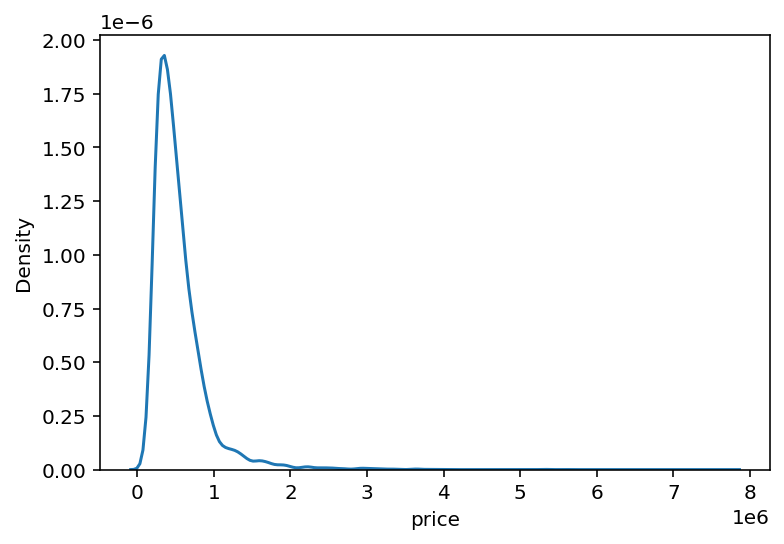

In [38]:
sns.kdeplot(y)
plt.show()

In [39]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

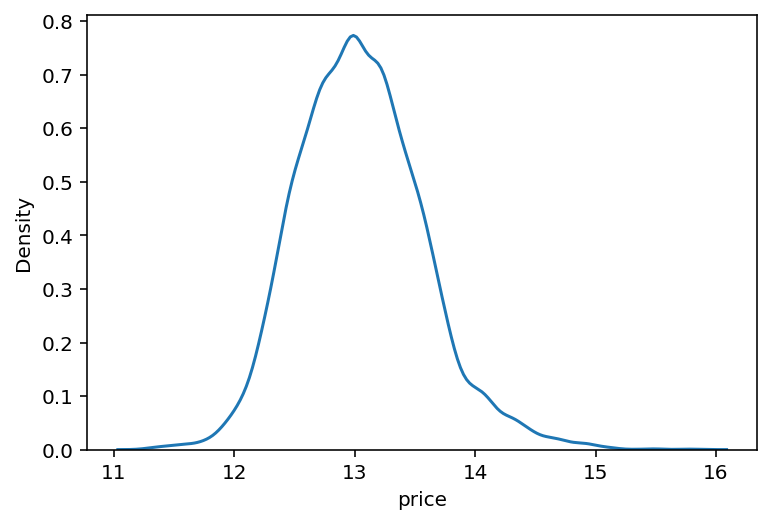

In [40]:
sns.kdeplot(y)
plt.show()

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

얍💢


In [43]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [111]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [112]:
xgboost = XGBRegressor(random_state=42)

In [ ]:
for k, v in params.items():
    if k not in init_params or (
            repr(v) != repr(init_params[k])
            and not (is_scalar_nan(init_params[k]) and is_scalar_nan(v))):
        filtered_params[k] = v

In [113]:
xgboost

KeyError: 'base_score'

KeyError: 'base_score'

In [104]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다.
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [47]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [50]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


In [51]:
from sklearn.model_selection import GridSearchCV

얍💢


In [62]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [110]:
models[3]

RandomForestRegressor(random_state=2020)

In [102]:
param_grid = {
    'max_depth': [1, 10, -1],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
    'n_estimators': [50, 60, 70, 80, 90, 100],
}

for model in models:
    model_name = model.__class__.__name__
    my_GridSearch(model_name, train, y, param_grid, verbose=2, n_jobs=5)

TypeError: estimator should be an estimator implementing 'fit' method, 'GradientBoostingRegressor' was passed

In [82]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    submission_path = join(PATH, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(PATH, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [75]:
PATH

'/aiffel/aiffel/aiffel/explorations/06_kaggle/data'

In [76]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/aiffel/explorations/06_kaggle/data/submission_lgbm_RMSLE_0.0168.csv saved!
